In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely.geometry as geom
from shapely.geometry import Point, LineString, box
import osmnx as ox
import random

In [3]:
place_name = "Bari, Italy"
G = ox.graph_from_place(place_name, network_type="drive")   # network_type can be changed
print("Nodes:", len(G.nodes()), "Edges:", len(G.edges()))

# Project graph to appropriate metric CRS (UTM)
G_proj = ox.project_graph(G)

Nodes: 6605 Edges: 13810


In [4]:
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G_proj, nodes=True, edges=True)
print("edges_gdf CRS:", edges_gdf.crs)
# reset index so u,v,key are columns (convenient)
edges_gdf = edges_gdf.reset_index()

# If an edge lacks geometry (rare after graph_to_gdfs), create a straight line between nodes:
def ensure_geometry(row, nodes_gdf):
    if row.geometry is None or row.geometry.is_empty:
        u = row['u']; v = row['v']
        pu = nodes_gdf.loc[u].geometry
        pv = nodes_gdf.loc[v].geometry
        return LineString([pu, pv])
    return row.geometry

edges_gdf['geometry'] = edges_gdf.apply(lambda r: ensure_geometry(r, nodes_gdf), axis=1)

# compute geometric length (meters, since projected)
edges_gdf['length_m'] = edges_gdf.geometry.length

edges_gdf.head()

edges_gdf CRS: EPSG:32633


,u,v,key,osmid,highway,lanes,maxspeed,name,oneway,ref,reversed,length,geometry,junction,bridge,width,access,tunnel,length_m
0,15502708,335571799,0,30859256,trunk,2,70,Strada Statale 16 Adriatica,True,SS16,False,173.607436,"LINESTRING (666920.91 4550349.319, 666869.324 ...",NaN,NaN,NaN,NaN,NaN,173.991839
1,335571799,332467221,0,30171916,residential,2,NaN,Prima Traversa Strada detta della Marina,False,NaN,True,178.437766,"LINESTRING (666752.744 4550393.605, 666763.843...",NaN,NaN,NaN,NaN,NaN,178.212106
2,335571799,335571539,0,30859256,trunk,2,70,Strada Statale 16 Adriatica,True,SS16,False,204.740389,"LINESTRING (666752.744 4550393.605, 666673.375...",NaN,NaN,NaN,NaN,NaN,205.201640
3,139164292,1637548788,0,150890373,residential,NaN,NaN,Via Vincenzo Calace,False,NaN,True,203.951090,"LINESTRING (654284.651 4553336.644, 654237.107...",NaN,NaN,NaN,NaN,NaN,203.836017
4,139164292,1637548845,0,734285482,secondary,2,30,Via Bruno Buozzi,False,NaN,False,61.802101,"LINESTRING (654284.651 4553336.644, 654304.054...",NaN,NaN,NaN,NaN,NaN,61.906448


In [11]:
def generate_points_along_edges(edges_gdf, spacing_m=40.0, offset_m=15.0):
    """
    edges_gdf: GeoDataFrame of edges in projected CRS (meters)
    spacing_m: distance between consecutive points along edge (meters)
    offset_m: distance from both ends to avoid intersection-proximate points (meters)
    
    Returns: GeoDataFrame of points (projected CRS) with columns:
        - edge_uid: unique identifier for the parent edge
        - u, v, key (copied from edge)
        - dist_along: distance along the geometry for that point
    """
    pts = []
    meta = []
    # ensure we have an explicit edge UID
    edges_gdf = edges_gdf.copy().reset_index(drop=True)
    edges_gdf['edge_uid'] = edges_gdf.index.astype(str)  # simple unique id as string
    
    for idx, row in edges_gdf.iterrows():
        line: LineString = row.geometry
        L = line.length
        if L <= 2 * offset_m:
            # edge too short to place any points respecting offset
            continue
        # distances along the line where we will place points
        distances = np.arange(offset_m, L - offset_m + 1e-8, spacing_m)
        for d in distances:
            pt = line.interpolate(d)
            pts.append(pt)
            meta.append({
                'edge_uid': row['edge_uid'],
                'u': row['u'], 'v': row['v'],
                'key': row.get('key', 0),
                'dist_along_m': float(d),
                'edge_length_m': float(L)
            })
    if len(pts) == 0:
        return gpd.GeoDataFrame(columns=['edge_uid','geometry']), edges_gdf
    pts_gdf = gpd.GeoDataFrame(meta, geometry=pts, crs=edges_gdf.crs)
    return pts_gdf, edges_gdf

spacing = 200.0
offset = 15.0
pts_proj_gdf, edges_with_uid = generate_points_along_edges(edges_gdf, spacing_m=spacing, offset_m=offset)
print("Points created (projected):", len(pts_proj_gdf))


Points created (projected): 12621


In [12]:
# transform to geographic coordinates for plotting with lat/lon axes
pts_wgs_gdf = pts_proj_gdf.to_crs(epsg=4326)
pts_wgs_gdf['lon'] = pts_wgs_gdf.geometry.x
pts_wgs_gdf['lat'] = pts_wgs_gdf.geometry.y
pts_wgs_gdf.head()

,edge_uid,u,v,key,dist_along_m,edge_length_m,geometry,lon,lat
0,0,15502708,335571799,0,15.0,173.991839,POINT (16.98715 41.08733),16.987155,41.087327
1,1,335571799,332467221,0,15.0,178.212106,POINT (16.98536 41.08785),16.985355,41.087850
2,2,335571799,335571539,0,15.0,205.201640,POINT (16.98516 41.08775),16.985162,41.087751
3,3,139164292,1637548788,0,15.0,203.836017,POINT (16.83762 41.1168),16.837624,41.116796
4,4,139164292,1637548845,0,15.0,61.906448,POINT (16.83787 41.11674),16.837865,41.116737


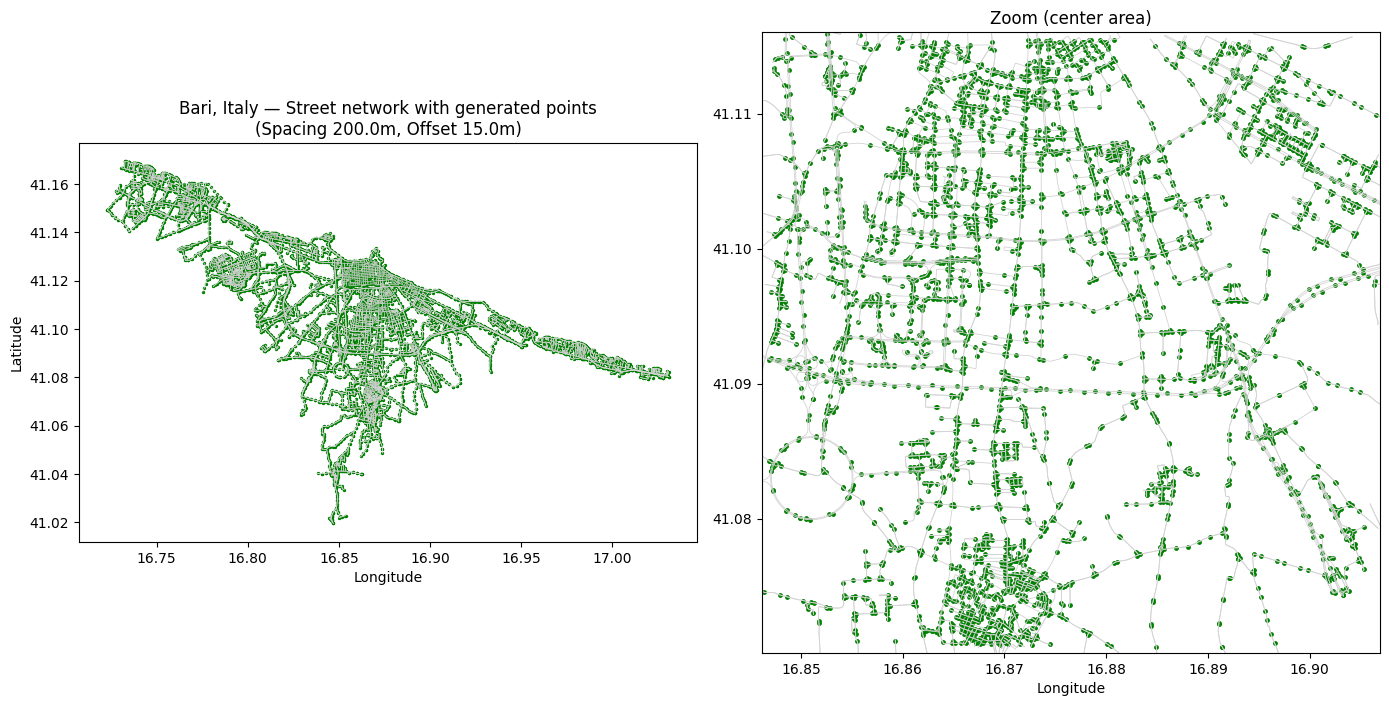

Saved figure bari_points_on_streets.png


In [13]:
# Convert edges back to WGS84 for plotting axes in lon/lat
edges_wgs = edges_with_uid.to_crs(epsg=4326)

# Prepare figure
fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=False)

# Left: full city (edges faint gray, points in one color)
edges_wgs.plot(ax=axes[0], linewidth=0.5, color='lightgray')
pts_wgs_gdf.plot(ax=axes[0], markersize=2, color='green', label=f'Points (spacing={spacing}m, offset={offset}m)')
axes[0].set_title(f"{place_name} — Street network with generated points\n(Spacing {spacing}m, Offset {offset}m)")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

# Right: zoomed area around city centroid (projected buffer then to wgs84)
# compute centroid in projected CRS for accurate meter buffer
bounds = edges_with_uid.total_bounds  # minx, miny, maxx, maxy in projected CRS
cx = (bounds[0] + bounds[2]) / 2.0
cy = (bounds[1] + bounds[3]) / 2.0
zoom_m = 2500.0  # zoom box half-width in meters
zoom_box_proj = box(cx - zoom_m, cy - zoom_m, cx + zoom_m, cy + zoom_m)
# convert the box to WGS84 for geographic plotting
zoom_gdf = gpd.GeoDataFrame(geometry=[zoom_box_proj], crs=edges_with_uid.crs)
zoom_gdf_wgs = zoom_gdf.to_crs(epsg=4326)
minx, miny, maxx, maxy = zoom_gdf_wgs.total_bounds

# plot only features inside zoom box
edges_zoom = edges_wgs[edges_wgs.intersects(zoom_gdf_wgs.geometry.iloc[0])]
pts_zoom = pts_wgs_gdf[pts_wgs_gdf.intersects(zoom_gdf_wgs.geometry.iloc[0])]

edges_zoom.plot(ax=axes[1], linewidth=0.6, color='lightgray')
pts_zoom.plot(ax=axes[1], markersize=6, color='green')
axes[1].set_xlim(minx, maxx)
axes[1].set_ylim(miny, maxy)
axes[1].set_title("Zoom (center area)")
axes[1].set_xlabel("Longitude")

plt.tight_layout()
plt.show()

# save to file if you want
fig.savefig("bari_points_on_streets.png", dpi=300)
print("Saved figure bari_points_on_streets.png")
